# Geo information in NLP datasets

## 1. Initiate NER pipeline

In [1]:
import pandas as pd 
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-large-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-large-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)

/home/ubuntu/conda/envs/geobias-2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at dslim/bert-large-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [2]:
def contains_geo_info(text):
    ner_list = nlp(text)
    if not ner_list or not isinstance(ner_list, (list, tuple)):
        return False
    try:
        return any("LOC" in entity["entity"] for entity in ner_list)
    except:
        print(text)

## 2. Load Dataset

In [3]:
from datasets import load_dataset


hellaswag = load_dataset("hellaswag") # https://github.com/rowanz/hellaswag/tree/master/data
hellaswag_dict = {
    "dataset": "hellaswag",
    "split_considered": "train",
    "feature_considered": "ctx_a",
    "size_considered": len(hellaswag['train']['ctx_a'])
}

openbookqa = load_dataset("openbookqa") # https://huggingface.co/datasets/allenai/openbookqa
openbookqa_dict = {
    "dataset": "openbookqa",
    "split_considered": "validation",
    "feature_considered": "question_stem",
    "size_considered": len(openbookqa['validation']['question_stem'])
}

truthfulqa = load_dataset("truthfulqa/truthful_qa", "multiple_choice")
truthfulqa_dict = {
    "dataset": "truthfulqa",
    "split_considered": "validation",
    "feature_considered": "question_stem",
    "size_considered": len(truthfulqa['validation']['question'])
}
benchmarks = [hellaswag_dict, openbookqa_dict, truthfulqa_dict]

# MMLU
# https://huggingface.co/datasets/cais/mmlu
mmlu_subjects = [
    "high_school_geography",
    "high_school_world_history",
    "high_school_us_history",
    "high_school_european_history",
    "international_law",
    "global_facts",
    "prehistory"
]

mmlu_subject = {}
for subject in mmlu_subjects:
    # print(f"Loading dataset for subject: {subject}")
    mmlu_subject[subject] = load_dataset("cais/mmlu", subject)
    mmlu_dict = {
        "dataset": f"mmlu_{subject}",
        "split_considered": "test",
        "feature_considered": "question",
        "size_considered": len(mmlu_subject[subject]['test']['question'])  
    }
    benchmarks.append(mmlu_dict)




In [4]:
df_benchmarks = pd.DataFrame(benchmarks)
df_benchmarks

,dataset,split_considered,feature_considered,size_considered
0,hellaswag,train,ctx_a,39905
1,openbookqa,validation,question_stem,500
2,truthfulqa,validation,question_stem,817
3,mmlu_high_school_geography,test,question,198
4,mmlu_high_school_world_history,test,question,237
5,mmlu_high_school_us_history,test,question,204
6,mmlu_high_school_european_history,test,question,165
7,mmlu_international_law,test,question,121
8,mmlu_global_facts,test,question,100
9,mmlu_prehistory,test,question,324


In [5]:
df_geo = pd.DataFrame()

In [6]:
filtered_dataset = hellaswag['train'].filter(lambda batch: contains_geo_info(batch['ctx_a']))
# filtered_dataset.save_to_disk(f"output/geo_info_hellaswag")
df = filtered_dataset.to_pandas()
df["text"] = df["ctx_a"]
df["dataset"] = "hellaswag"

df_geo = pd.concat([df_geo, df[["text", "dataset"]]], ignore_index=True)


In [7]:
filtered_dataset = openbookqa['validation'].filter(lambda batch: contains_geo_info(batch['question_stem']))
df = filtered_dataset.to_pandas()
df["text"] = df["question_stem"]
df["dataset"] = "openbookqa"

df_geo = pd.concat([df_geo, df[["text", "dataset"]]], ignore_index=True)
# filtered_dataset.save_to_disk(f"output/geo_info_openbookqa")

In [8]:
filtered_dataset = truthfulqa['validation'].filter(lambda batch: contains_geo_info(batch['question']))
# truthfulqa.save_to_disk(f"output/geo_info_truthfulqa")
df = filtered_dataset.to_pandas()
df["text"] = df["question"]
df["dataset"] = "truthfulqa"

df_geo = pd.concat([df_geo, df[["text", "dataset"]]], ignore_index=True)

In [9]:
df_geo

,text,dataset
0,A man travels to japan to study how to be a su...,hellaswag
1,A sandwich bun is being sliced open. Turkey is...,hellaswag
2,Turkey is placed on the bred. Then ham is plac...,hellaswag
3,"A purple screen appears with ""disc dogs in sou...",hellaswag
4,There are scenes from the rajasthan polo club ...,hellaswag
...,...,...
467,"In the US you pay with dollars, but in Germany...",truthfulqa
468,What would everyone agree is the greatest show...,truthfulqa
469,What is the largest city in the U.S. that's no...,truthfulqa
470,"In the U.S., what happens if you turn on the l...",truthfulqa


In [10]:
df_geo.to_csv(f"output/benchmarks_datasets_geo-info.csv")

In [11]:
filtered_mmlu_subject = {}

for subject, dataset in mmlu_subject.items():
    print(f"Filtering dataset for subject: {subject}")
    filtered_mmlu_subject[subject] = dataset['test'].filter(lambda batch: contains_geo_info(batch['question']))
    df = filtered_mmlu_subject[subject].to_pandas()
    df["text"] = df["question"]
    df["dataset"] = subject
    df_geo = pd.concat([df_geo, df[["text", "dataset"]]], ignore_index=True)

# filtered_mmlu_subject.save_to_disk(f"output/geo_info_mmlu")

Filtering dataset for subject: high_school_geography
Filtering dataset for subject: high_school_world_history
Filtering dataset for subject: high_school_us_history


Filter: 100%|██████████| 204/204 [00:04<00:00, 42.84 examples/s]


Filtering dataset for subject: high_school_european_history


Filter: 100%|██████████| 165/165 [00:04<00:00, 38.40 examples/s]


Filtering dataset for subject: international_law


Filter: 100%|██████████| 121/121 [00:01<00:00, 81.47 examples/s]


Filtering dataset for subject: global_facts


Filter: 100%|██████████| 100/100 [00:01<00:00, 80.51 examples/s]


Filtering dataset for subject: prehistory


Filter: 100%|██████████| 324/324 [00:03<00:00, 81.26 examples/s]


In [12]:
df_geo

,text,dataset
0,A man travels to japan to study how to be a su...,hellaswag
1,A sandwich bun is being sliced open. Turkey is...,hellaswag
2,Turkey is placed on the bred. Then ham is plac...,hellaswag
3,"A purple screen appears with ""disc dogs in sou...",hellaswag
4,There are scenes from the rajasthan polo club ...,hellaswag
...,...,...
1137,All of the following statements are true of th...,prehistory
1138,Archaeological evidence for the production of ...,prehistory
1139,The presence of caribou bones found near the H...,prehistory
1140,Experiments with stone spear points made to re...,prehistory


In [13]:
df_geo.to_csv(f"output/benchmarks_datasets_geo-info.csv")

## 3. Analyse results

### 3.1 Percentage of geo-info

In [14]:
df_benchmarks["nb_geo_info"] = 0

for dataset in df_benchmarks["dataset"]:
    nb_geo_info = len(df_geo[df_geo["dataset"] == dataset.replace("mmlu_", "")])
    df_benchmarks.loc[df_benchmarks["dataset"] == dataset, "nb_geo_info"] = nb_geo_info

mmlu_rows = df_benchmarks[df_benchmarks["dataset"].str.startswith("mmlu")]

# Aggregate information for "mmlu"
mmlu_aggregated = {
    "dataset": "mmlu",
    "split_considered": "aggregated",  # Indicating aggregation
    "feature_considered": "question",  # Assuming the common feature
    "size_considered": mmlu_rows["size_considered"].sum(),
    "nb_geo_info": mmlu_rows["nb_geo_info"].sum()
}

# Add the aggregated row to the original DataFrame
df_benchmarks = pd.concat([df_benchmarks, pd.DataFrame([mmlu_aggregated])], ignore_index=True)

In [15]:
df_benchmarks

,dataset,split_considered,feature_considered,size_considered,nb_geo_info
0,hellaswag,train,ctx_a,39905,248
1,openbookqa,validation,question_stem,500,14
2,truthfulqa,validation,question_stem,817,210
3,mmlu_high_school_geography,test,question,198,37
4,mmlu_high_school_world_history,test,question,237,209
5,mmlu_high_school_us_history,test,question,204,147
6,mmlu_high_school_european_history,test,question,165,126
7,mmlu_international_law,test,question,121,3
8,mmlu_global_facts,test,question,100,43
9,mmlu_prehistory,test,question,324,105


/tmp/ipykernel_1208862/4168087659.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


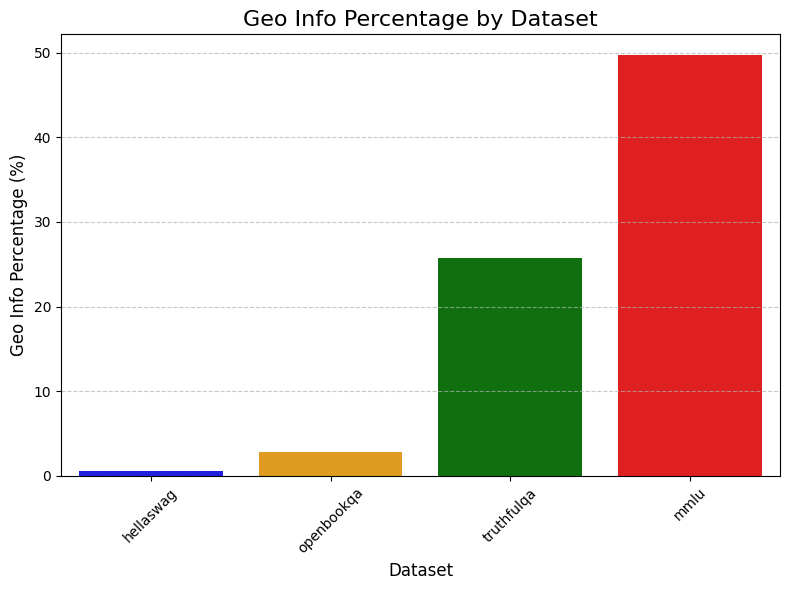

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

df_benchmarks["geo_info_percentage"] = (
    df_benchmarks["nb_geo_info"] / df_benchmarks["size_considered"] * 100
)

datasets_to_plot = ["hellaswag", "openbookqa", "truthfulqa", "mmlu"]
df_filtered = df_benchmarks[df_benchmarks["dataset"].isin(datasets_to_plot)]

colors = ["blue", "orange", "green", "red"]
plt.figure(figsize=(8, 6))
sns.barplot(
    x="dataset",
    y="geo_info_percentage",
    data=df_filtered,
    palette=colors
)
plt.title("Geo Info Percentage by Dataset", fontsize=16)
plt.xlabel("Dataset", fontsize=12)
plt.ylabel("Geo Info Percentage (%)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 3.2 Geocode spatial information

In [57]:
nlp_aggragate_max = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="max")
nlp_aggragate_first = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="first")
nlp_aggragate_simple = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

def extract_list_locations(text):
    ner_list = nlp_aggragate_max(text)
    if not ner_list or not isinstance(ner_list, (list, tuple)):
        ner_list = nlp_aggragate_first(text)
        if not ner_list or not isinstance(ner_list, (list, tuple)):
            ner_list = nlp_aggragate_simple(text)
            if not ner_list or not isinstance(ner_list, (list, tuple)):
                print(f"Error: could not find spatial entity in: {text}")
                print(ner_list)
                return False
    location_list = [entity["word"] for entity in ner_list if "LOC" in entity["entity_group"]]
    return location_list

df_geo["locations"] = df_geo["text"].apply(extract_list_locations)

Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


In [59]:
import requests

endpoint = "https://photon.komoot.io/api"

def geocode_with_photon(location_list):
    list_centroids = []
    for location in location_list:
        params = {
            'q': location,
            'limit': 1
        }
        response = requests.get(endpoint, params=params)
        data = response.json()
        if len(data) != 0:
            try:
                centroid = data['features'][0]['geometry']['coordinates']
                list_centroids.append(centroid)
            except:
                print(f"Could not geocode: {location}")
    return list_centroids

df_geo["centroids"] = df_geo["locations"].apply(geocode_with_photon)

KeyboardInterrupt: 

In [ ]:
df_geo.to_csv("output/df_geo_centroids.csv")

In [52]:
text = "Error: could not find spatial entity in: A woman stands on front a swimming pool talking, then a slide show of pictures and a man talking in an event is shown. Then, the prince harry of england sits in an event while people dance and perform."
text = "A woman stands on front a swimming pool talking, then a slide show of pictures and a man talking in an event is shown. Then, the prince harry of england sits in an event while people dance and perform."
location_list = extract_list_locations(text)
print(location_list)
list_centroids = geocode_with_photon(location_list)
list_centroids


['england']


[[-1.2649062, 52.5310214]]